# Gensim NMF vs other models

In [1]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import CoherenceModel, LdaModel
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [2]:
categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

trainset = fetch_20newsgroups(subset='train', categories=categories, random_state=42)
testset = fetch_20newsgroups(subset='test', categories=categories, random_state=42)

In [3]:
from gensim.parsing.preprocessing import preprocess_documents

train_documents = preprocess_documents(trainset.data)

In [4]:
from gensim.corpora import Dictionary

dictionary = Dictionary(train_documents)

dictionary.filter_extremes()

2018-09-26 16:17:36,495 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-09-26 16:17:37,601 : INFO : built Dictionary(25279 unique tokens: ['angu', 'bb', 'carri', 'demonstr', 'dragon']...) from 2819 documents (total 435348 corpus positions)
2018-09-26 16:17:37,670 : INFO : discarding 18197 tokens: [('angu', 2), ('edu', 1785), ('line', 2748), ('lussmyer', 1), ('organ', 2602), ('subject', 2819), ('write', 1743), ('absood', 4), ('deragatori', 3), ('indistinct', 3)]...
2018-09-26 16:17:37,671 : INFO : keeping 7082 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2018-09-26 16:17:37,684 : INFO : resulting dictionary: Dictionary(7082 unique tokens: ['bb', 'carri', 'demonstr', 'dragon', 'exactli']...)


In [5]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(train_documents))
proba_bow_matrix = bow_matrix / bow_matrix.sum(axis=0)

## Gensim NMF vs Gensim LDA

In [6]:
training_params = dict(
    corpus=corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0
)

### Training time

In [14]:
%%time

np.random.seed(42)

gensim_nmf = GensimNmf(
    **training_params,
    use_r=True,
    lambda_=10,
    sparse_coef=3
)

2018-09-26 16:21:23,154 : INFO : Loss (no outliers): 605.4539794750594	Loss (with outliers): 532.3720940408144
2018-09-26 16:21:24,937 : INFO : Loss (no outliers): 618.9506306166222	Loss (with outliers): 505.24146249601546


CPU times: user 8.69 s, sys: 954 ms, total: 9.65 s
Wall time: 9.7 s


In [15]:
%lprun -f GensimNmf._solveproj gensim_nmf = GensimNmf(**training_params, use_r=True, lambda_=10)

2018-09-26 16:22:24,489 : INFO : Loss (no outliers): 616.4966110494801	Loss (with outliers): 533.5107297438328
2018-09-26 16:22:26,366 : INFO : Loss (no outliers): 603.170374269566	Loss (with outliers): 498.6201255460912


In [49]:
%%time

np.random.seed(42)

gensim_lda = LdaModel(**training_params)

2018-09-26 15:05:58,281 : INFO : using symmetric alpha at 0.2
2018-09-26 15:05:58,283 : INFO : using symmetric eta at 0.2
2018-09-26 15:05:58,287 : INFO : using serial LDA version on this node
2018-09-26 15:05:58,295 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 1000 documents, evaluating perplexity every 2819 documents, iterating 50x with a convergence threshold of 0.001000
2018-09-26 15:05:58,297 : INFO : PROGRESS: pass 0, at document #1000/2819
2018-09-26 15:05:59,253 : INFO : merging changes from 1000 documents into a model of 2819 documents
2018-09-26 15:05:59,260 : INFO : topic #0 (0.200): 0.006*"com" + 0.006*"like" + 0.005*"think" + 0.004*"host" + 0.004*"peopl" + 0.004*"nntp" + 0.004*"univers" + 0.004*"know" + 0.004*"armenian" + 0.004*"new"
2018-09-26 15:05:59,262 : INFO : topic #1 (0.200): 0.007*"peopl" + 0.005*"com" + 0.005*"univers" + 0.004*"like" + 0.004*"time" + 0.004*"space" + 0.0

KeyboardInterrupt: 

### Coherence

In [9]:
gensim_nmf_cm = CoherenceModel(
    model=gensim_nmf,
    corpus=corpus,
    coherence='u_mass'
)

gensim_nmf_cm.get_coherence()

2018-09-26 16:19:18,699 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-09-26 16:19:18,724 : INFO : CorpusAccumulator accumulated stats from 2000 documents


-1.4685017455113438

In [20]:
gensim_lda_cm = CoherenceModel(
    model=gensim_lda,
    corpus=corpus,
    coherence='u_mass'
)

gensim_lda_cm.get_coherence()

2018-09-25 15:43:37,196 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-09-25 15:43:37,224 : INFO : CorpusAccumulator accumulated stats from 2000 documents


-1.7217224975861698

### Perplexity

In [21]:
def perplexity(model, corpus):
    W = gensim_nmf.get_topics().T

    H = np.zeros((W.shape[1], len(corpus)))
    for bow_id, bow in enumerate(corpus):
        for topic_id, proba in model[bow]:
            H[topic_id, bow_id] = proba
    
    dense_corpus = matutils.corpus2dense(corpus, W.shape[0])
    
    return np.exp(-(np.log(W.dot(H), where=W.dot(H)>0) * dense_corpus).sum() / dense_corpus.sum())

In [22]:
perplexity(gensim_nmf, corpus)

/home/anotherbugmaster/Documents/gensim/gensim/models/nmf.py:94: RuntimeWarning: invalid value encountered in true_divide
  return self._W.T.toarray() / self._W.T.toarray().sum(axis=1).reshape(-1, 1)
/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/scipy/sparse/base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


KeyboardInterrupt: 

In [ ]:
perplexity(gensim_lda, corpus)

### Topics

In [10]:
gensim_nmf.show_topics()

[(0,
  '0.025*"said" + 0.020*"peopl" + 0.020*"know" + 0.016*"went" + 0.015*"apart" + 0.014*"azerbaijani" + 0.013*"came" + 0.013*"sai" + 0.013*"come" + 0.012*"start"'),
 (1,
  '0.037*"imag" + 0.037*"jpeg" + 0.020*"file" + 0.016*"format" + 0.014*"program" + 0.013*"us" + 0.012*"displai" + 0.011*"softwar" + 0.011*"version" + 0.011*"avail"'),
 (2,
  '0.016*"peopl" + 0.012*"israel" + 0.011*"like" + 0.009*"isra" + 0.009*"right" + 0.009*"god" + 0.009*"think" + 0.008*"know" + 0.008*"time" + 0.008*"question"'),
 (3,
  '0.083*"armenian" + 0.033*"turkish" + 0.021*"turk" + 0.019*"armenia" + 0.017*"peopl" + 0.016*"russian" + 0.015*"genocid" + 0.014*"muslim" + 0.014*"turkei" + 0.014*"argic"'),
 (4,
  '0.040*"space" + 0.016*"nasa" + 0.012*"orbit" + 0.011*"satellit" + 0.010*"launch" + 0.010*"data" + 0.009*"new" + 0.008*"mission" + 0.008*"includ" + 0.008*"technolog"')]

In [ ]:
gensim_lda.show_topics()

## Gensim NMF vs Sklearn NMF

In [17]:
W = gensim_nmf.get_topics().T
H = np.zeros((W.shape[1], len(corpus)))
for bow_id, bow in enumerate(corpus):
    for topic_id, proba in gensim_nmf[bow]:
        H[topic_id, bow_id] = proba

In [18]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

8.762690688242715

In [19]:
%%time

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(proba_bow_matrix)
H = sklearn_nmf.components_

CPU times: user 32.2 s, sys: 7.12 s, total: 39.3 s
Wall time: 12.2 s


In [20]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

8.300690481807766

## Sklearn wrapper

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.nmf = GensimNmf(**kwargs)
        self.corpus = None
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def fit(self, X):
        self.corpus = [
            [
                (feature_idx, value)
                for feature_idx, value
                in enumerate(sample)
            ]
            for sample
            in X
        ]
        
        self.nmf.update(self.corpus)
        
    def transform(self, X):
        H = np.zeros((len(self.corpus), self.nmf.num_topics))
        for bow_id, bow in enumerate(self.corpus):
            for topic_id, proba in self.nmf[bow]:
                H[bow_id, topic_id] = proba
                
        return H
        
    @property
    def components_(self):
        return self.nmf.get_topics()

## Olivietti faces + Gensim NMF


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.175s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.757s
Extracting the top 6 Non-negative components - NMF (Gensim)...


2018-09-25 19:37:46,019 : INFO : Loss (no outliers): 4.667153263442201	Loss (with outliers): 4.667153263442201
2018-09-25 19:38:15,294 : INFO : Loss (no outliers): 5.627424232391022	Loss (with outliers): 5.627424232391022
2018-09-25 19:38:42,054 : INFO : Loss (no outliers): 4.6702664790116435	Loss (with outliers): 4.6702664790116435
2018-09-25 19:39:09,601 : INFO : Loss (no outliers): 5.475740164257109	Loss (with outliers): 5.475740164257109
2018-09-25 19:39:09,605 : INFO : Loss (no outliers): 5.475740164257109	Loss (with outliers): 5.475740164257109


done in 109.365s
Extracting the top 6 Independent components - FastICA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


done in 0.426s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.286s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 2.630s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.148s
Extracting the top 6 Factor Analysis components - FA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.306s


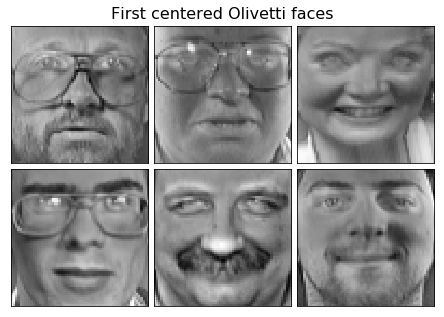

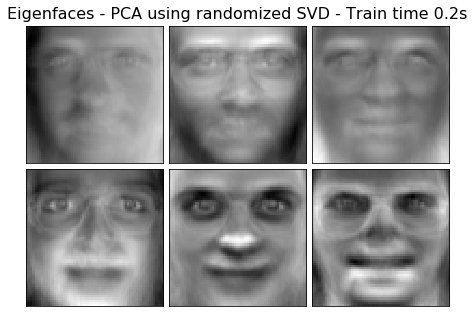

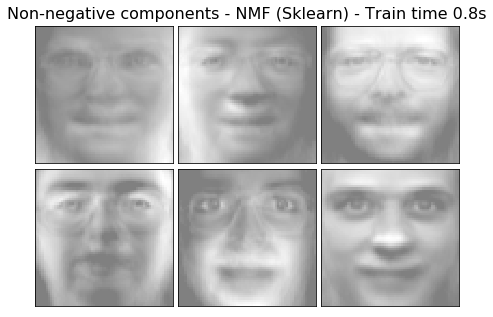

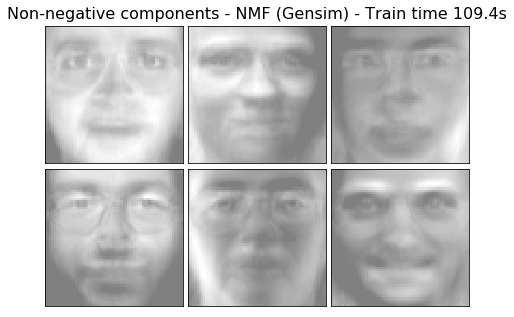

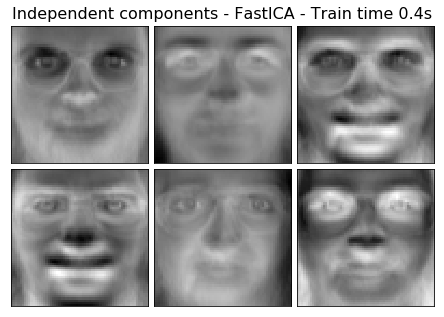

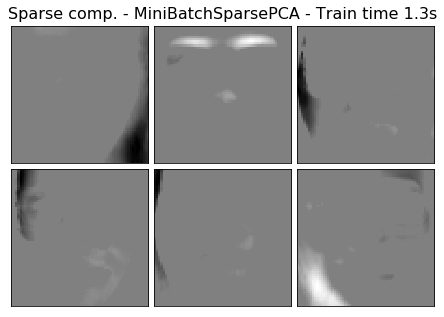

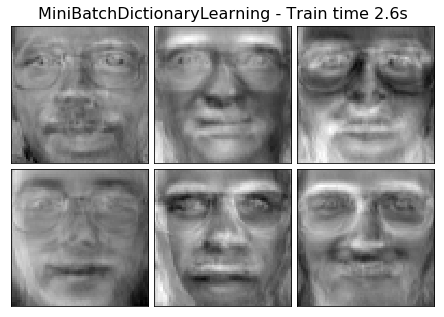

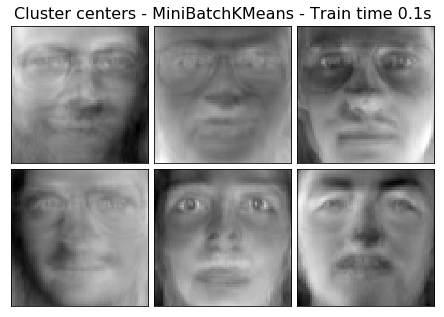

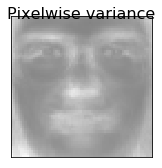

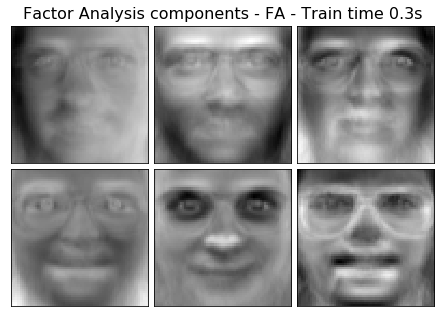

In [70]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),
    
    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
        chunksize=1,
        use_r=True,
        lambda_=0.5,
        eval_every=1000,
        passes=10,
        sparse_coef=0,
        id2word={idx:idx for idx in range(faces.shape[1])},
        num_topics=n_components,
        minimum_probability=0
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

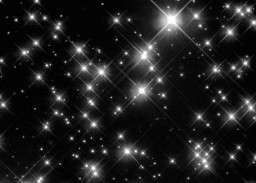

In [42]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [43]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [44]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 527 ms, sys: 476 ms, total: 1 s
Wall time: 279 ms


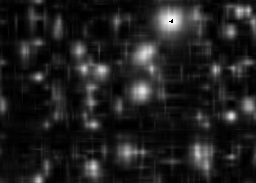

In [45]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [46]:
np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

In [47]:
%%time

import itertools

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    passes=1,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000,
    kappa=1,
    normalize=False
)

2018-09-25 00:56:44,027 : INFO : Loss (no outliers): 2009.7411222788025	Loss (with outliers): 2009.7411222788025


CPU times: user 413 ms, sys: 0 ns, total: 413 ms
Wall time: 415 ms


In [49]:
W = gensim_nmf.get_topics().T
H = np.zeros((W.shape[1], len(matutils.Dense2Corpus(img_matrix.T))))
for bow_id, bow in enumerate(matutils.Dense2Corpus(img_matrix.T)):
    for topic_id, proba in gensim_nmf[bow]:
        H[topic_id, bow_id] = proba

ValueError: setting an array element with a sequence.

### Reconstructed matrix:

In [ ]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')